In [1]:
from pprint import pprint
from utils.data_transformation import if_in_date_range
%matplotlib inline
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

from matplotlib.pyplot import figure
import plotly.graph_objects as go

ImportError: cannot import name 'Exception' from 'api' (/Users/akurochkin/testenv/lib/python3.8/site-packages/api/__init__.py)

In [123]:
# 1) Change USER_ID and paths to your dir locations=======================================
# you can get your USER_ID from downloaded csv files

# set paths to dirs in data dir
path_data_dir = os.path.join(os.getcwd(), "data")

path_dialogs_meta_dir = os.path.join(path_data_dir, "dialogs_meta")
path_dialogs_dir = os.path.join(path_data_dir, "dialogs")

path_to_dialogs_info = "dialogs_info.json"

USER_ID = 511986933
RESULT_NAME_STATISTICS = "dialogs_data"

In [124]:
dialogs_info = {
    "Private dialog": {},
    "Group": {},
    "Channel": {}
}

# make dialogs_info dict: first level keys - "Channel", "Private dialog", "Group"
# second level items - "<name_of_dialog>": <id>
for file in os.listdir(path_dialogs_meta_dir):
    if file[-4:] == "json":
        with open(os.path.join(path_dialogs_meta_dir, file), "r", encoding="utf8") as meta_file:
            data = json.load(meta_file)

        dialogs_info[data["type"]][data["name"]] = data["id"]

# 1) save results
with open(path_to_dialogs_info, "w", encoding="utf-8") as f:
    json.dump(dialogs_info, f, indent=4, ensure_ascii=False)

# print("dialogs_info")
# pprint(dialogs_info)

## Plot of daily activity (09.08.2020)

In [125]:
# TODO: write such functions is a antipattern.
# such code is a spagetti code
# you should: 1. decompose it on the simpler methods, 2. move all constants as (40 + 30) to the variables and comment logic behind them

def get_hours_dict():
    plot_data = {}
    for hour in range(24):
        if hour < 10:
            hour = '0' + str(hour)
            plot_data[hour] = 0
        else:
            plot_data[str(hour)] = 0
    return plot_data


def get_our_local_time(msg_time):
    our_local_time = int(msg_time) + 2
    if our_local_time < 10:
        our_local_time = "0" + str(our_local_time)

    else:
        our_local_time = str(our_local_time)

    return our_local_time


def get_user_daily_activity(dialogs_info, dialog_type, user_id_get_msg, date_before, date_after):
    plot_data = get_hours_dict()

    # go through all dialogs on special dialog type in dialogs_info dict
    # friend - name of dialog
    for friend, dialog_id in dialogs_info[dialog_type].items():
        dialog_id = str(dialog_id)
        if dialog_id + ".csv" not in os.listdir(path_dialogs_dir):
            continue

        dialog_data = pd.read_csv(os.path.join(path_dialogs_dir, dialog_id + ".csv"))

        for row in dialog_data.index:
            if user_id_get_msg != "all":
                if dialog_data["from_id"][row] != user_id_get_msg:
                    continue

            dialog_datetime = dialog_data["date"][row][:-6]
            flag_in_range = if_in_date_range(dialog_datetime, date_before, date_after)
            if flag_in_range == 'Dialog after date_after':
                continue

            elif not flag_in_range:
                break

            elif flag_in_range:
                our_local_time = get_our_local_time(dialog_data['date'][row][11:13])
                plot_data[our_local_time] += 1

    lists = sorted(plot_data.items())
    x, y = zip(*lists)

    return x, y, lists

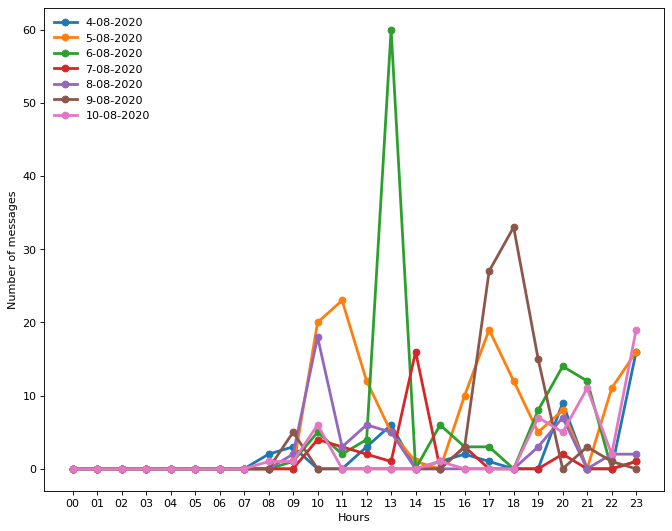

In [127]:
# TODO: 1. add some explanation to the plot: title, labels for axises, maybe legend. Now it tells nothing
# TODO: 2. fix KeyError: '24'


figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
fig = go.Figure()

for i in range(7):
    date_before = datetime.datetime(2020, 8, 3 + i, 0, 0, 0)
    date_after = datetime.datetime(2020, 8, 4 + i, 0, 0, 0)

    x, y, lists = get_user_daily_activity(dialogs_info, "Private dialog", USER_ID, date_before, date_after)

    fig.add_trace(go.Bar(
        y=x,
        x=y,
        name="{}-08-2020".format(4 + i),
        orientation='h',
        marker=dict(
            line=dict(color='rgb(105, 105, 105, 1.0)', width=3)
        )
    ))
    plt.plot(x, y, linewidth=2.5, marker='o', linestyle="-", label="{}-08-2020".format(4 + i))

plt.xticks([i for i in range(0, 24)])
plt.xlabel("Hours")
plt.ylabel("Number of messages")
plt.legend(loc='upper left', frameon=False)
plt.show()

# show comparing bar
fig.update_layout(
    barmode='stack',
    autosize=False,
    width=800,
    height=800,
    yaxis = dict(
            title='Hours',
            titlefont_size=16,
            tickfont_size=14,
            tickmode = 'array',
            tickvals = [i for i in range(24)]),
    xaxis = dict(
            title='Number of messages',
            titlefont_size=16,
            tickfont_size=14)
)
fig.show()

## Collect general statistics for user during DATE_BEFORE - DATE_AFTER

In [128]:
def get_statistics_msgs(df, user_id_get_msg, dialog_type, statistics_type,
                        date_before, date_after):
    """

    :param df: your dataframe
    :param user_id_get_msg: int, user id
    :param dialog_type: "Channel" or "Private dialog" or "Group"
    :param statistics_type: "received" or "sent", to analyse received or sent messages
    :param date_before: datetime type, from what time start to analyse msgs
    :param date_after: datetime type, to what time to analyse msgs
    :return: added dataframe with statistics in range (date_before, date_after) and
    average_n_msgs, average_n_words
    """
    dialogs_places_dict = {}

    # go through all dialogs on special dialog type in dialogs_info dict
    # friend - name of dialog
    msgs_lst, words_lst = [], []
    for friend, dialog_id in dialogs_info[dialog_type].items():
        dialog_id = str(dialog_id)
        if dialog_id + ".csv" not in os.listdir(path_dialogs_dir):
            msgs_lst.append(0)
            words_lst.append(0)
            dialogs_places_dict[friend] = 0
            continue

        dialog_data = pd.read_csv(os.path.join(path_dialogs_dir, dialog_id + ".csv"))

        # if it is Group, so to get number of received messages to you in it
        # it is sent to_id like PeerChannel(channel_id=1387547322), it is not your id
        # so we change it
        if dialog_type == "Group" and statistics_type == "received":
            user_id_get_msg = dialog_data["to_id"][dialog_data.index[0]]

        n_msgs_in_date_range, n_words_in_date_range = 0, 0
        dialogs_places_dict[friend] = 0

        for row in dialog_data.index:
            dialog_datetime = dialog_data["date"][row][:-6]
            flag_in_range = if_in_date_range(dialog_datetime, date_before, date_after)
            if flag_in_range == 'Dialog after date_after':
                continue

            if not flag_in_range:
                break

            if statistics_type == "received":
                if dialog_data["from_id"][row] == user_id_get_msg:
                    continue
                    
            elif statistics_type == "sent":
                if dialog_data["from_id"][row] != user_id_get_msg:
                    continue

            if not pd.isnull(dialog_data["message"][row]):
                n_words_in_date_range += len(dialog_data["message"][row].split())
            dialogs_places_dict[friend] = dialogs_places_dict.get(friend, 0) + 1

        words_lst.append(n_words_in_date_range)

    dialogs_places_dict = {k: v for k, v in sorted(dialogs_places_dict.items(), key=lambda item: item[1], reverse=True)}
    msgs_lst = []
    for i in df.index:
        msgs_lst.append(dialogs_places_dict[df["dialog_name"][i]])

    df["n_{}_msgs_in_date_range".format(statistics_type)] = msgs_lst
    df["n_{}_words_in_date_range".format(statistics_type)] = words_lst

    df["place_dialog_by_n_{}_msgs".format(statistics_type)] = [0 for _ in range(len(df.index))]

    print("Top 10 {} by {} messages during {} - {}".format(dialog_type, statistics_type, DATE_BEFORE, DATE_AFTER))
    for place, friend in enumerate(dialogs_places_dict.items()):
        if place < 10:
            print("{} place is {} with {} messages".format(place + 1, friend[0], friend[1]))
        n_row = df.loc[df['dialog_name'] == friend[0]]["id"]
        df["place_dialog_by_n_{}_msgs".format(statistics_type)][n_row] = place + 1

    print("\n\n")
    average_n_msgs = int(df["n_{}_msgs_in_date_range".format(statistics_type)].mean(skipna = True))
    average_n_words = int(df["n_{}_words_in_date_range".format(statistics_type)].mean(skipna = True))

    return df, average_n_msgs, average_n_words


# TODO: are these recived messages? or sent? can you pls give statistics for both(sent and recived). store this in the dataframe

# 2) Change DATE_BEFORE and DATE_AFTER to yours===================================

# from what time start to analyse msgs - to what time to analyse msgs
DATE_BEFORE = datetime.datetime(2017, 1, 10, 0, 0, 0)
DATE_AFTER = datetime.datetime(2020, 8, 10, 0, 0, 0)

# get general statistics
df = pd.DataFrame(dialogs_info["Private dialog"].items(), columns=["dialog_name", "dialog_id"])
df["id"] = [i for i in range(df.index[-1] + 1)]

## Top people with whom communicate during DATE_BEFORE - DATE_AFTER

In [129]:
df, average_n_received_msgs, average_n_received_words = get_statistics_msgs(df, USER_ID, "Private dialog", "received",
                                                                            DATE_BEFORE, DATE_AFTER)
df, average_n_sent_msgs, average_n_sent_words = get_statistics_msgs(df, USER_ID, "Private dialog", "sent",
                                                                    DATE_BEFORE, DATE_AFTER)

new_row = {
    "dialog_name": "Total average statistics msgs",
    "dialog_id": -1,
    "n_received_msgs_in_date_range": average_n_received_msgs,
    "n_received_words_in_date_range": average_n_received_words,
    "n_sent_msgs_in_date_range": average_n_sent_msgs,
    "n_sent_words_in_date_range": average_n_sent_words,
    "place_dialog_by_n_received_msgs": -1,
    "place_dialog_by_n_sent_msgs": -1
}

df = df.append(new_row, ignore_index=True)

df.to_csv(os.path.join("data", "tmp_static", f"private_{RESULT_NAME_STATISTICS}.csv"))
df

Top 10 Private dialog by received messages during 2017-01-10 00:00:00 - 2020-08-10 00:00:00
1 place is H_bot with 1428 messages
2 place is H_bot29.06 with 1323 messages
3 place is Harmix with 1172 messages
4 place is Назар Поночевний with 901 messages
5 place is NewsKit with 901 messages
6 place is Клименко with 848 messages
7 place is Діма Лопушанський with 828 messages
8 place is Добосевич Олесь with 708 messages
9 place is Паша Уку Астроном with 691 messages
10 place is Elena Lazarus with 656 messages



Top 10 Private dialog by sent messages during 2017-01-10 00:00:00 - 2020-08-10 00:00:00
1 place is Denys Herasymuk with 1973 messages
2 place is Добосевич Олесь with 1286 messages
3 place is Паша Уку Астроном with 966 messages
4 place is Назар Поночевний with 957 messages
5 place is Цапів Володимир Аі with 957 messages
6 place is Клименко with 895 messages
7 place is Діма Лопушанський with 809 messages
8 place is H_bot29.06 with 572 messages
9 place is H_bot with 572 messages
10 pla

d:\python\envs\venv_telegram_analysis\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,dialog_name,dialog_id,id,n_received_msgs_in_date_range,n_received_words_in_date_range,place_dialog_by_n_received_msgs,n_sent_msgs_in_date_range,n_sent_words_in_date_range,place_dialog_by_n_sent_msgs
0,Harmix,1001618937,0.0,1172,16736,3,531,486,12
1,Берегов,1002879007,1.0,1,0,198,0,0,218
2,Pastukh Yaroslav,100314790,2.0,0,0,257,0,0,219
3,Іра Їжачок,1013106861,3.0,1,0,199,0,0,220
4,Гордіян Олег Вікторович Баня,1019177627,4.0,1,0,200,0,0,221
...,...,...,...,...,...,...,...,...,...
269,Maria Danchak,988636074,269.0,7,35,152,3,33,189
270,Тарас Карате Адвокат,994276855,270.0,1,0,254,0,0,271
271,Аліна Авраменко,995165576,271.0,1,0,255,0,0,272
272,Приставка,997302074,272.0,1,0,256,0,0,273


In [130]:
# TODO: add same calculations for number of words. add it to the same dataframe

## Top groups with whom communicate during DATE_BEFORE - DATE_AFTER

In [131]:
# get general statistics
df_groups = pd.DataFrame(dialogs_info["Group"].items(), columns=["dialog_name", "dialog_id"])
df_groups["id"] = [i for i in range(df_groups.index[-1] + 1)]

df_groups, average_n_received_msgs, average_n_received_words = get_statistics_msgs(df_groups, "all", "Group", "received",
                                                                            DATE_BEFORE, DATE_AFTER)
df_groups, average_n_sent_msgs, average_n_sent_words = get_statistics_msgs(df_groups, USER_ID, "Group", "sent",
                                                                    DATE_BEFORE, DATE_AFTER)

new_row = {
    "dialog_name": "Total average statistics msgs",
    "dialog_id": -1,
    "n_received_msgs_in_date_range": average_n_received_msgs,
    "n_received_words_in_date_range": average_n_received_words,
    "n_sent_msgs_in_date_range": average_n_sent_msgs,
    "n_sent_words_in_date_range": average_n_sent_words,
    "place_dialog_by_n_received_msgs": -1,
    "place_dialog_by_n_sent_msgs": -1
}

df = df.append(new_row, ignore_index=True)

df.to_csv(os.path.join("data", "tmp_static", f"groups_{RESULT_NAME_STATISTICS}.csv"))
df

Top 10 Group by received messages during 2017-01-10 00:00:00 - 2020-08-10 00:00:00
1 place is Крильце Надії with 2000 messages
2 place is 🤪Будущі бомжі (4K)🥴 with 2000 messages
3 place is English 5 група with 2000 messages
4 place is UGS 2019 Finalists 2.0 with 2000 messages
5 place is CS & BA 2019 💚💜 with 1998 messages
6 place is CS‘19👨🏻‍💻 with 1997 messages
7 place is 2.0 Головна бесіда колегіуму без спаму with 1994 messages
8 place is UGS Q&A with 1983 messages
9 place is AI challenge with 1977 messages
10 place is APPS@UCU (всі) ❤️ with 1861 messages



Top 10 Group by sent messages during 2017-01-10 00:00:00 - 2020-08-10 00:00:00
1 place is AI challenge with 1161 messages
2 place is Group with 799 messages
3 place is Курси та навчання with 190 messages
4 place is Груповуха з ****** with 159 messages
5 place is Центр опіки сиріт with 146 messages
6 place is Gettothedream with 134 messages
7 place is d2v with 77 messages
8 place is AI Guardians - Ukraine team with 61 messages
9 plac

d:\python\envs\venv_telegram_analysis\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,dialog_name,dialog_id,id,n_received_msgs_in_date_range,n_received_words_in_date_range,place_dialog_by_n_received_msgs,n_sent_msgs_in_date_range,n_sent_words_in_date_range,place_dialog_by_n_sent_msgs
0,Harmix,1001618937,0.0,1172,16736,3,531,486,12
1,Берегов,1002879007,1.0,1,0,198,0,0,218
2,Pastukh Yaroslav,100314790,2.0,0,0,257,0,0,219
3,Іра Їжачок,1013106861,3.0,1,0,199,0,0,220
4,Гордіян Олег Вікторович Баня,1019177627,4.0,1,0,200,0,0,221
...,...,...,...,...,...,...,...,...,...
270,Тарас Карате Адвокат,994276855,270.0,1,0,254,0,0,271
271,Аліна Авраменко,995165576,271.0,1,0,255,0,0,272
272,Приставка,997302074,272.0,1,0,256,0,0,273
273,Total average statistics msgs,-1,NaN,68,705,-1,71,699,-1


## Time spending on conversations during DATE_BEFORE - DATE_AFTER

In [134]:
# 3) Change to yours===================================

# add UNPREDICTABLE_EXTRA_TIME minutes TO get_user_active_minutes_per_day in case of unpredictable situations
UNPREDICTABLE_EXTRA_TIME = 5

# add TIME_FOR_FIRST_YOUR_MESSAGE sec - time for reading yur friend messages or one message + writing your first message
TIME_FOR_FIRST_YOUR_MESSAGE = 40

# if time between messages is more TIME_BETWEEN_USER_REPLIES sec,
# so the dialog is stopped and
# we should not add this time to general time
TIME_BETWEEN_USER_REPLIES = 600


def get_user_active_minutes_per_day(dialogs_info, date_before, date_after, dialog_type, user_id_get_msg):
    """

    :param dialogs_info: dict: first level keys - "Channel", "Private dialog", "Group"
    second level items - "<name_of_dialog>": <id>
    :param date_before: datetime type, from what time start to analyse msgs
    :param date_after: datetime type, to what time to analyse msgs
    :param dialog_type: "Channel" or "Private dialog" or "Group"
    :param user_id_get_msg: int, user id
    :return: lists for a plot of "top_friends" or "daily_activity", depends on
    your input plot_type
    """
    dialog_active_minutes, previous_message_time = 0, 0

    # go through all dialogs on special dialog type in dialogs_info dict
    # friend - name of dialog
    print(f"Active minutes per day({date_before}) in {dialog_type}")
    for friend, dialog_id in dialogs_info[dialog_type].items():
        dialog_id = str(dialog_id)
        start_dialog_time, stop_dialog_time = 0, 0
        if dialog_id + ".csv" not in os.listdir(path_dialogs_dir):
            continue

        dialog_data = pd.read_csv(os.path.join(path_dialogs_dir, dialog_id + ".csv"))
        dialog_active_minutes_before = dialog_active_minutes
        flag_first_my_message = 0

        for row in dialog_data.index:
            if user_id_get_msg != "all":
                if dialog_data["from_id"][row] != user_id_get_msg:
                    continue

            dialog_datetime = dialog_data["date"][row][:-6]
            flag_in_range = if_in_date_range(dialog_datetime, date_before, date_after)
            if flag_in_range == 'Dialog after date_after':
                continue

            elif not flag_in_range:
                break

            elif flag_in_range:
                dialog_datetime = datetime.datetime.strptime(dialog_data["date"][row][:-6],
                                                                         "%Y-%m-%d %H:%M:%S")
                if flag_first_my_message == 0:
                    previous_message_time = dialog_datetime
                    flag_first_my_message = 1

                time_before_my_messages = previous_message_time - dialog_datetime

                # if message in user_id_get_msg queue of messages
                if row != dialog_data.index[-1] and dialog_data["from_id"][row + 1] == user_id_get_msg and \
                        time_before_my_messages.total_seconds() < 600:
                    previous_message_time = dialog_datetime
                    if stop_dialog_time == 0:
                        stop_dialog_time = dialog_datetime

                else:
                    if stop_dialog_time == 0:
                        # if in user_id_get_msg queue of messages is only 1 message so add
                        # time for writing it
                        dialog_active_minutes += TIME_FOR_FIRST_YOUR_MESSAGE
                    else:
                        start_dialog_time = dialog_datetime

                        # get time between your query of messages
                        time_since = stop_dialog_time - start_dialog_time

                        # if time between messages is more TIME_BETWEEN_USER_REPLIES sec,
                        # so the dialog is stopped and
                        # we should not add this time to general time
                        if time_since.total_seconds() >= TIME_BETWEEN_USER_REPLIES:
                            time_since = stop_dialog_time - previous_message_time
                            dialog_active_minutes += time_since.total_seconds() + TIME_FOR_FIRST_YOUR_MESSAGE
                            # TIME_FOR_LAST_MESSAGE

                        else:
                            # add TIME_FOR_FIRST_YOUR_MESSAGE sec - time for reading + writing first message
                            dialog_active_minutes += time_since.total_seconds() + TIME_FOR_FIRST_YOUR_MESSAGE

                    previous_message_time = dialog_datetime
                    start_dialog_time, stop_dialog_time = 0, 0

        if (dialog_active_minutes - dialog_active_minutes_before) // 60 > 0:
            print("Time spend on conversation: dialog {} {} minutes".format(friend,
                                                                            (dialog_active_minutes -
                                                                             dialog_active_minutes_before) // 60))
    print("\n")
    # add UNPREDICTABLE_EXTRA_TIME minutes in case of unpredictable situations
    return dialog_active_minutes // 60 + UNPREDICTABLE_EXTRA_TIME


Active minutes per day(2020-08-01 00:00:00) in Private dialog
Time spend on conversation: dialog Діма Лопушанський 22.0 minutes
Time spend on conversation: dialog Andrew Kurochkin 4.0 minutes
Time spend on conversation: dialog Назар Поночевний 2.0 minutes
Time spend on conversation: dialog Султанов Андрій 2.0 minutes
Time spend on conversation: dialog Max Bilyk 11.0 minutes
Time spend on conversation: dialog Паша Уку Астроном 3.0 minutes
Time spend on conversation: dialog Євген Домерецький 10.0 minutes
Time spend on conversation: dialog Цапів Володимир Аі 4.0 minutes


Active minutes per day(2020-08-01 00:00:00) in Group
Time spend on conversation: dialog AI challenge 4.0 minutes


Active minutes per day(2020-08-02 00:00:00) in Private dialog
Time spend on conversation: dialog Назар Поночевний 5.0 minutes


Active minutes per day(2020-08-02 00:00:00) in Group


Active minutes per day(2020-08-03 00:00:00) in Private dialog
Time spend on conversation: dialog Діма Лопушанський 1.0 minutes

In [ ]:
# TODO: it's not okay to have so mane KEYERROR!!!s, something in the logic is wrong
# table with time spend on the dialog should be in the dataframe
# when I dwar chart for long time period(7 months) I see same bars, with values 7000minutes per day, are you sure it's okay?

# 4) Change START_WEEK_YEAR, START_WEEK_MONTH and START_WEEK_DAY to yours===================================

# be sure to input date which is in your data, not date in the future !!!
START_WEEK_YEAR = 2020
START_WEEK_MONTH = 8
START_WEEK_DAY = 1

plot_data = {}
for i in range(7):
    date_before = datetime.datetime(START_WEEK_YEAR, START_WEEK_MONTH,
                                    START_WEEK_DAY + i, 0, 0, 0)

    date_after = datetime.datetime(START_WEEK_YEAR, START_WEEK_MONTH,
                                    START_WEEK_DAY + i + 1, 0, 0, 0)

    general_dialog_time = get_user_active_minutes_per_day(dialogs_info, date_before, date_after, "Private dialog", USER_ID) \
                          + get_user_active_minutes_per_day(dialogs_info, date_before, date_after, "Group", USER_ID)
    plot_data[datetime.date(START_WEEK_YEAR, START_WEEK_MONTH, START_WEEK_DAY + i)] = general_dialog_time

lists = sorted(plot_data.items())
dates, n_minutes_lst = zip(*lists)

In [133]:
import plotly.graph_objects as px


plot = px.Figure(data=[go.Bar(
    name = 'Data 1',
    x = dates,
    y = n_minutes_lst
   )])

plot.update_layout(
    autosize=False,
    width=800,
    height=800,
    yaxis = dict(
            title='N minutes',
            titlefont_size=16,
            tickfont_size=14),
    xaxis = dict(
            title='Dates',
            titlefont_size=16,
            tickfont_size=14)
)

plot.show()

